# Assignment 1
The purpose of this assignment is to reproduce the following experiment: train a neural network which takes in input a binary vector of 6 digits and detects if the vector is symmetric in respect to the center or not. This notebook is composed as follows:
- Generation of the dataset
- Generation of the neural network
- Definition the parameters
- Training the network
- Analysis
- Possible improvements

In [1]:
import torch
import itertools
import matplotlib.pyplot as plt

## Generation of the dataset
The dataset is composed of the 64 possible vectors, labelled 1 if the vector is symmetric and 0 otherwise. 

In [2]:
def calculate_label_of_vector(x):
    """Returns the label of a vector."""
    return 1 if x[2] == x[3] and x[1] == x[4] and x[0] == x[5] else 0

In [3]:
def build_dataset():
    """Builds the dataset."""
    X = torch.tensor(list(itertools.product([0,1],repeat=6)),dtype=torch.float32)
    Y = torch.tensor([calculate_label_of_vector(x) for x in X], dtype=torch.float32)
    return X,Y

X,Y = build_dataset()

## Generation of the neural network
The network has been built as specified in the paper:
- 6 input nodes
- 1 hidden layer with 2 nodes
- 1 output node

The non-linearity in every connection and in the output is obtained using a sigmoid. Moreover, every weight and bias has been initialized uniformally between -0.3 and 0.3.

In [4]:
class BinaryCLassifier(torch.nn.Module):
    """Builds the network as specified: 
        - 6 input nodes
        - 1 hidden layer with 2 nodes
        - 1 output node
        The non-linearity in every connection and in the output is obtained using a sigmoid."""
    
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features = 6, out_features = 2, bias = True)
        self.layer2 = torch.nn.Linear(in_features = 2, out_features = 1, bias = True)
        self.activation = torch.nn.Sigmoid()
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Initializes weights and biases uniformally between -0.3 and 0.3"""
        if isinstance(module, torch.nn.Linear):
            module.weight.data.uniform_(-0.3, 0.3)
            module.bias.data.uniform_(-0.3, 0.3)
    
    def forward(self,x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        return x
    
model = BinaryCLassifier()

In [5]:
def calculate_accuracy(model, X, Y):
    """Evaluates the accuracy based on the entire dataset"""
    model.eval()
    with torch.no_grad():
        correct = 0
        out = model(X).reshape(64)
        correct += (abs(out - Y) < 0.5).int().sum()
        return float(correct/len(X))

## Definition the parameters
To train the model there has been used:
- Stochastic Gradient Descent with a constant learning rate of 0.1 and a momentum of 0.9
- Mean Squared Error as loss function

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)

loss = torch.nn.MSELoss()

## Training the network
As specified in the paper, the entire dataset has been swept 1425 times and for every sweep the weights and biases has been updated according to the descent.

Final accuracy:  0.875


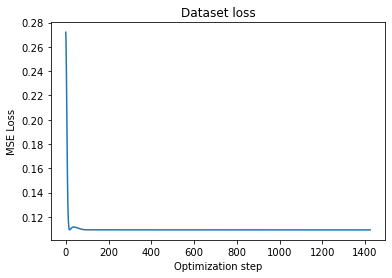

In [7]:
epochs = 1425
losses = []
for epoch in range(epochs):
    model.train()
    out = model(X).reshape(64)
    l = loss(out, Y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    losses.append(l.item())
    
print("Final accuracy: ", calculate_accuracy(model, X, Y))

plt.figure()
plt.title("Dataset loss")
plt.plot(losses)
plt.xlabel("Optimization step")
_ = plt.ylabel("MSE Loss")

### Weigths and biases obtained

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,":",sep="")
        for value in param.data:
            print("\t",value)
        print()

layer1.weight:
	 tensor([ 0.0824, -0.1075,  0.2577,  0.3316,  0.0528, -0.0193])
	 tensor([ 0.2730,  0.0862,  0.3192,  0.2130, -0.1792,  0.3206])

layer1.bias:
	 tensor(0.0430)
	 tensor(0.1086)

layer2.weight:
	 tensor([-0.8553, -0.6961])

layer2.bias:
	 tensor(-1.0021)



## Analysis
The obtained results were very disappointing, since no symmetric vector has been detected. The final accuracy is $\frac{56}{64} = 0.875$, so every non-symmetric vector is correctly classified, but none of the 8 symmetric vectors are correctly classified.

In [9]:
number_of_non_symmetric = int((out < 0.5).float().sum())
print("Number of vectors classified as non-symmetric:", number_of_non_symmetric)

Number of vectors classified as non-symmetric: 64


The learning procedure has not found the weights and biases as in the paper, so the neural network is not capable of detecting symmetry in binary vectors, even though the same procedure has been followed. Maybe with some improvements the network will be able to detect the symmetric vectors.

## Possible improvements
The proposed improvements are:
- Change the optimizer algotirthm to "Adam" to smoothen the descent to the minimum and regularise the parameters
- Use a scheduler to use a dynamic learning rate so to descend "slower" near the minimum
- Change the loss function to the Binary Cross Entropy, which is better suited for binary classification than the MSE

In [10]:
model = BinaryCLassifier()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss = torch.nn.BCELoss()

Final accuracy:  0.875


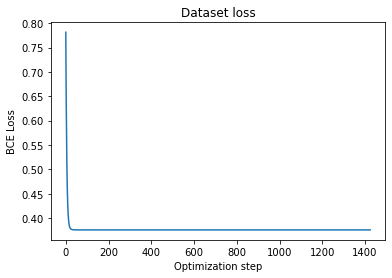

In [11]:
epochs = 1425
losses = []
for epoch in range(epochs):
    model.train()
    out = model(X).reshape(64)
    l = loss(out, Y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()
    losses.append(l.item())
    
print("Final accuracy: ", calculate_accuracy(model, X, Y))

plt.figure()
plt.title("Dataset loss")
plt.plot(losses)
plt.xlabel("Optimization step")
_ = plt.ylabel("BCE Loss")

In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,":",sep="")
        for value in param.data:
            print("\t",value)
        print()

layer1.weight:
	 tensor([0.7992, 0.6254, 0.6465, 0.8882, 0.4864, 0.5978])
	 tensor([ 0.0718, -0.0804,  0.1522,  0.2408,  0.1084,  0.1703])

layer1.bias:
	 tensor(0.8724)
	 tensor(0.0335)

layer2.weight:
	 tensor([-0.8608, -0.6364])

layer2.bias:
	 tensor(-0.6623)



### Analysis

In [13]:
number_of_non_symmetric = int((out < 0.5).float().sum())
print("Number of vectors classified as non-symmetric:", number_of_non_symmetric)

Number of vectors classified as non-symmetric: 64


Even though there have been used several improvements, the network is still useless for our goal. Some explenations might be:
- The small imbalanced dataset
- Not enough nodes in the hidden layer